# Following the low level tutorial guide
This code is currently looking at this IRIS observation:

DST flare watch coordination, 2014-10-25 14:58:28-18:00:56

OBS 3880106953: Large sit-and-stare

https://www.lmsal.com/hek/hcr?cmd=view-event&event-id=ivo%3A%2F%2Fsot.lmsal.com%2FVOEvent%23VOEvent_IRIS_20141025_145828_3880106953_2014-10-25T14%3A58%3A282014-10-25T14%3A58%3A28.xml

In [1]:
%matplotlib inline
import gzip
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import pandas as pd
from lmfit import Model
# Set up some default matplotlib options
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

## RASTER FILES

In [2]:
# opens the IRIS fits file
sp = fits.open("20141025raster.fits")

In [3]:
# doublecheck what type of observation we have
hd = sp[0].header
hd['OBS_DESC']

'Large sit-and-stare 0.3x120 1s  C II   Mg II h/k   Mg II w Deep x 4'

In [4]:
# print name & index of each spectral line
print('Window. Name      : wave start - wave end\n')
for i in range(hd['NWIN']):
    win = str(i + 1)
    print('{0}. {1:15}: {2:.2f} - {3:.2f} Å'
          ''.format(win, hd['TDESC' + win], hd['TWMIN' + win], hd['TWMAX' + win]))

Window. Name      : wave start - wave end

1. C II 1336      : 1331.69 - 1358.32 Å
2. Si IV 1394     : 1380.77 - 1406.70 Å
3. Mg II k 2796   : 2783.32 - 2834.96 Å


In [5]:
# Set which line to look at
line_num = 2

In [6]:
# changing this value to 1 was necessary to use the wcs transformation code (something to do with making sure the transformation matrix is non-singular)
# however I don't think we even need actual Sun coords anwyway
if sp[line_num].header['CDELT3']==0:
    sp[line_num].header['CDELT3']=1

In [7]:
# This code is sorcery I don't understand that gets us the wavelength information
wcs = WCS(sp[line_num].header)
m_to_nm = 1e9  # convert wavelength to nm
nwave = sp[line_num].data.shape[2]
wavelength = wcs.all_pix2world(np.arange(nwave), [0.], [0.], 0)[0] * m_to_nm

# Spectroheliograms

In [8]:
# The position of the 1393.757 Å line
line_index_1394 = np.argmin(np.abs(wavelength - 139.3757))
print(line_index_1394)

510


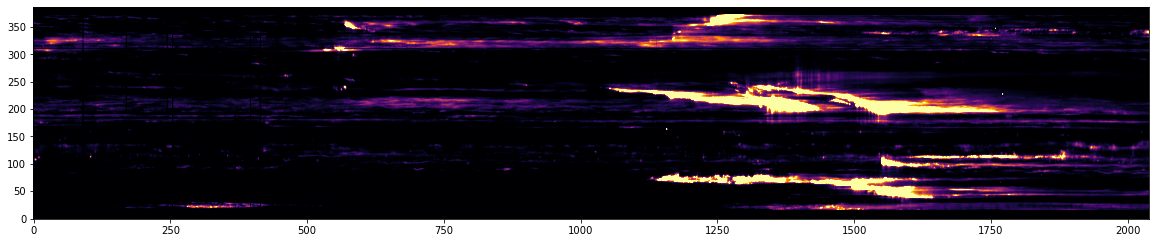

In [9]:
# plot the brightness in the 1394 line. y axis = slit position, x axis = time
plt.figure(figsize=(20, 20))

plt.imshow(sp[line_num].data[..., line_index_1394].T, vmin=100, vmax=2000)

In [10]:
# Let's get the flare data
temp_data = sp[line_num].data

In [11]:
# create an array containing the timestamps of the data (as strings)
time_diff = sp[-2].data[:, sp[-2].header['TIME']]
times_temp = np.datetime64(hd['DATE_OBS']) + time_diff * np.timedelta64(1, 's')
times_string = np.datetime_as_string(times_temp)
times = []
for letter in np.arange(0, len(times_string)):
    times.append(times_string[letter][11:-4])

# Gaussian Analysis

### Gaussian Analysis Test

testing lmfit

In [22]:
### which pixel?
test_t = 1282
test_y = 370

[[Model]]
    (Model(gauss1) + Model(gauss2))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 201
    # data points      = 36
    # variables        = 6
    chi-square         = 3395.32262
    reduced chi-square = 113.177421
    Akaike info crit   = 175.678865
    Bayesian info crit = 185.179978
[[Variables]]
    A1:      4821.64538 +/- 623.104414 (12.92%) (init = 2657.078)
    mu1:     139.387155 +/- 0.00107418 (0.00%) (init = 139.3757)
    sigma1:  0.00966838 +/- 3.4889e-04 (3.61%) (init = 0.01)
    A2:      5271.40078 +/- 720.980811 (13.68%) (init = 5314.155)
    mu2:     139.378689 +/- 5.0221e-04 (0.00%) (init = 139.3857)
    sigma2:  0.00549440 +/- 5.4083e-04 (9.84%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, A2)        = 0.889
    C(A1, A2)         = -0.876
    C(A1, mu1)        = -0.856
    C(A1, sigma2)     = -0.850
    C(mu1, sigma2)    = 0.831
    C(A2, sigma2)     = 0.703
    C(A1, mu2)        = -0.638
    C(m

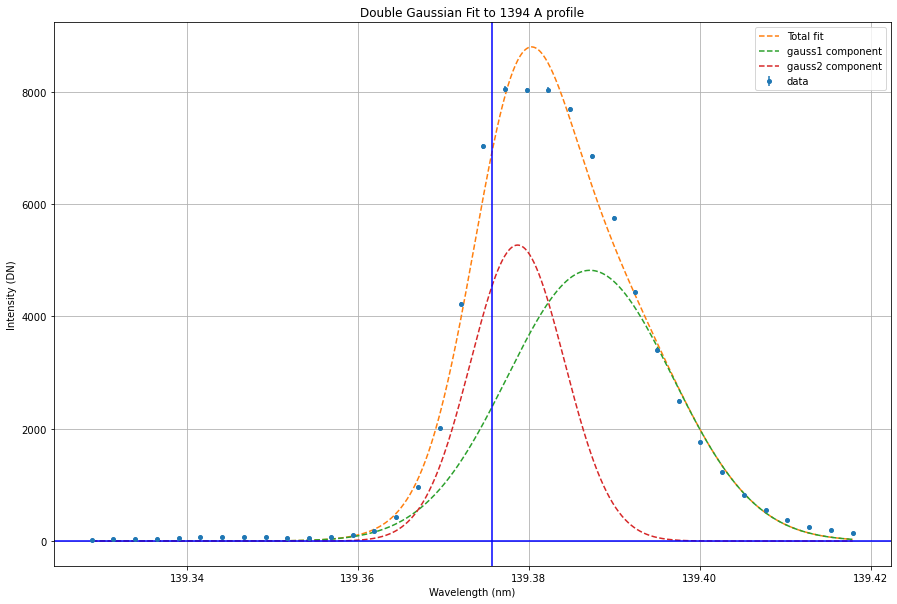

In [24]:
# Test on the 1394 line - we need to extract this from the full spectral data
# we use the two line_index variables found previously, but we want to be able to select a specific wavelength range around the reference wavelength

li_1394_upper = np.argmin(np.abs(wavelength - 139.42))
li_1394_lower = np.argmin(np.abs(wavelength - 139.33))

# extract the desired data range
test_gauss_x = wavelength[li_1394_lower:li_1394_upper]
test_gauss_y_32 = sp[line_num].data[test_t, test_y, li_1394_lower:li_1394_upper]
test_gauss_y = test_gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data
test_y_error = np.sqrt(np.absolute(test_gauss_y)/4)+1.5

# dummy x 
dummytest = np.linspace(np.min(test_gauss_x), np.max(test_gauss_x), 1000)

# Then we can perform a Gaussian fit to the line profile
# initial guesses
mean = 139.3757
sigma = 0.01
background = 1

def gauss1(x,A1,mu1,sigma1):
    return A1*np.exp(-(x-mu1)**2/2/sigma1**2)

def gauss2(x,A2,mu2,sigma2):
    return A2*np.exp(-(x-mu2)**2/2/sigma2**2)

def backgroundFunc(x,slope,intercept):
    return slope*x + intercept

compositeModel = Model(gauss1) + Model(gauss2)# + Model(backgroundFunc)

compositeModel.set_param_hint('A1', value=0.33*max(test_gauss_y), min=0)
compositeModel.set_param_hint('mu1', value=mean, min=139.36, max=139.42)
compositeModel.set_param_hint('sigma1', value=sigma)
compositeModel.set_param_hint('A2', value=0.66*max(test_gauss_y))
compositeModel.set_param_hint('mu2', value=mean+0.01, min=139.36, max=139.42)
compositeModel.set_param_hint('sigma2', value=sigma)
#compositeModel.set_param_hint('slope', value=1, min=0.5, max=1.5)
#compositeModel.set_param_hint('intercept', value=1, max=2)
params = compositeModel.make_params()

compResult = compositeModel.fit(test_gauss_y, params, x=test_gauss_x, weights=1/test_y_error)

print(compResult.fit_report())
#result.ci_report()
#compResult.plot(yerr=test_y_error, numpoints=1000, show_init=True)

comps = compResult.eval_components()
predicted = compositeModel.eval(compResult.params, x=dummytest)
predGauss1 = Model(gauss1).eval(compResult.params, x=dummytest)
predGauss2 = Model(gauss2).eval(compResult.params, x=dummytest)

plt.errorbar(test_gauss_x,test_gauss_y, yerr=test_y_error, fmt='o', ms=4, label='data')
plt.plot(dummytest, predicted, '--', label='Total fit')
plt.plot(dummytest, predGauss1, '--', label='gauss1 component')
plt.plot(dummytest, predGauss2, '--', label='gauss2 component')
#plt.plot(test_gauss_x, comps['backgroundFunc'], '--', label='background')
plt.grid(which='major')
plt.axhline(y=0, color='b', linestyle='-')
plt.axvline(x=139.3757, color='b', linestyle='-')
plt.legend()
plt.title('Double Gaussian Fit to 1394 A profile')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (DN)')
plt.show()

In [ ]:
# Test on the 1403 line - we need to extract this from the full spectral data
# we use the two line_index variables found previously, but we want to be able to select a specific wavelength range around the reference wavelength

li_1403_upper = np.argmin(np.abs(wavelength - 140.33))
li_1403_lower = np.argmin(np.abs(wavelength - 140.24))

# extract the desired data range
test_gauss_x = wavelength[li_1403_lower:li_1403_upper]
test_gauss_y_32 = sp[line_num].data[test_t, test_y, li_1403_lower:li_1403_upper]
test_gauss_y = test_gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data

test_y_error = np.sqrt(np.absolute(test_gauss_y)/4)+1.5

# dummy x 
dummytest = np.linspace(np.min(test_gauss_x), np.max(test_gauss_x), 1000)

# Then we can perform a Gaussian fit to the line profile
# initial guesses
mean = 140.2772
sigma = 0.01
background = 1

def gauss3(x,A3,mu3,sigma3):
    return A3*np.exp(-(x-mu3)**2/2/sigma3**2)

compositeModel = Model(gauss1) + Model(gauss2)# + Model(gauss3)

compositeModel.set_param_hint('A1', value=0.66*max(test_gauss_y), min=0)
compositeModel.set_param_hint('mu1', value=mean, min=140.26, max=140.32)
compositeModel.set_param_hint('sigma1', value=sigma)
compositeModel.set_param_hint('A2', value=0.33*max(test_gauss_y), min=0)
compositeModel.set_param_hint('mu2', value=mean+0.01, min=140.26, max=140.32)
compositeModel.set_param_hint('sigma2', value=sigma)
#compositeModel.set_param_hint('A3', value=0.05*max(test_gauss_y), min=0)
#compositeModel.set_param_hint('mu3', min=140.24, max=140.265, value=140.25)
#compositeModel.set_param_hint('sigma3', value=sigma)
#compositeModel.set_param_hint('slope', value=1, min=0.5, max=1.5)
#compositeModel.set_param_hint('intercept', value=1, min=-2, max=2)
params = compositeModel.make_params()

compResult = compositeModel.fit(test_gauss_y, params, x=test_gauss_x, weights=1/test_y_error)

print(compResult.fit_report())
#result.ci_report()
#compResult.plot(yerr=test_y_error, numpoints=1000, show_init=True)

comps = compResult.eval_components()
predicted = compositeModel.eval(compResult.params, x=dummytest)
predGauss1 = Model(gauss1).eval(compResult.params, x=dummytest)
predGauss2 = Model(gauss2).eval(compResult.params, x=dummytest)
#predGauss3 = Model(gauss3).eval(compResult.params, x=dummytest)

plt.errorbar(test_gauss_x,test_gauss_y, yerr=test_y_error, fmt='o', ms=4, label='data')
plt.plot(dummytest, predicted, '--', label='Total fit')
plt.plot(dummytest, predGauss1, '--', label='gauss1 component')
plt.plot(dummytest, predGauss2, '--', label='gauss2 component')
#plt.plot(dummytest, predGauss3, '--', label='gauss3 component')
plt.grid(which='major')
plt.axhline(y=0, color='b', linestyle='-')
plt.axvline(x=140.2772, color='b', linestyle='-')
plt.legend()
plt.title('Double Gaussian Fit to 1403 A profile')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (DN)')
plt.show()

## Loop Code without Chi test

In [ ]:
# create the array with 100 x 2040 data points - one for each data point in the area of interest - with columms for:
# time & slit coordinate, max intensity for both lines, a flag for if lines are single Gaussian, and all Gauss info
# the y-coordinate will be zero-based from y = 288 on the spectroheliograph
lmfitResultsArray = np.zeros((2040, 85, 37))

# line ranges
li_1394_upper = np.argmin(np.abs(wavelength - 139.42))
li_1394_lower = np.argmin(np.abs(wavelength - 139.33))

li_1403_upper = np.argmin(np.abs(wavelength - 140.33))
li_1403_lower = np.argmin(np.abs(wavelength - 140.24))

# x data
x1394 = wavelength[li_1394_lower:li_1394_upper]
dummyx1394 = np.linspace(np.min(x1394), np.max(x1394), 1800)
x1403 = wavelength[li_1403_lower:li_1403_upper] 
dummyx1403 = np.linspace(np.min(x1403), np.max(x1403), 1800)

# slit positions used
startslit = 288
endslit = 373
#endslit = 289

# construct composite models
def gauss1(x,A1,mu1,sigma1):
    return A1*np.exp(-(x-mu1)**2/2/sigma1**2)

def gauss2(x,A2,mu2,sigma2):
    return A2*np.exp(-(x-mu2)**2/2/sigma2**2)

def gauss3(x,A3,mu3,sigma3):
    return A3*np.exp(-(x-mu3)**2/2/sigma3**2)

def backgroundFunc(x,slope,intercept):
    return slope*x + intercept

doubleGaussModel = Model(gauss1) + Model(gauss2)# + Model(backgroundFunc)
tripleGaussModel = Model(gauss1) + Model(gauss2) + Model(gauss3)

# initial guesses
mean_1394 = 139.3757
mean_1403 = 140.2772
sigma = 0.01
background = 1

gny = 0
success_1394 = 0
success_1403 = 0
for gy in np.arange(startslit, endslit):
    print(gy)
    for gt in np.arange(0, 2040):
        # store coords of this point
        lmfitResultsArray[gt, gny, 0] = gt
        lmfitResultsArray[gt, gny, 1] = gy
        
        # extract the desired data range
        gauss_y_32 = sp[line_num].data[gt, gy, li_1394_lower:li_1394_upper]
        gauss_y = gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data
        yError = np.sqrt(np.absolute(gauss_y)/4)+1.5
        #store intensity at this point
        lmfitResultsArray[gt, gny, 2] = max(gauss_y)
        
        doubleGaussModel.set_param_hint('A1', value=0.33*max(gauss_y), min=0)
        doubleGaussModel.set_param_hint('mu1', value=mean_1394, min=139.36, max=139.42)
        doubleGaussModel.set_param_hint('sigma1', value=sigma)
        doubleGaussModel.set_param_hint('A2', value=0.66*max(gauss_y), min=0)
        doubleGaussModel.set_param_hint('mu2', value=mean_1394+0.02, min=139.36, max=139.42)
        doubleGaussModel.set_param_hint('sigma2', value=sigma)
        #doubleGaussModel.set_param_hint('slope', value=1, min=0.5, max=1.5)
        #doubleGaussModel.set_param_hint('intercept', value=1, max=2)
        paramsDouble = doubleGaussModel.make_params()
        
        # perform the Gaussian fit
        try:
            result1394 = doubleGaussModel.fit(gauss_y, paramsDouble, x=x1394, weights=1/yError)
            success_1394 = 1
            lmfitResultsArray[gt, gny, 5] = np.max(doubleGaussModel.eval(result1394.params, x=dummyx1394))
            lmfitResultsArray[gt, gny, 6] = dummyx1394[np.argmax(doubleGaussModel.eval(result1394.params, x=dummyx1394))]
            lmfitResultsArray[gt, gny, 7] = result1394.chisqr
            lmfitResultsArray[gt, gny, 8] = result1394.redchi
            # 1st gauss fitted parameters
            lmfitResultsArray[gt, gny, 9] = result1394.params['A1'].value
            lmfitResultsArray[gt, gny, 10] = result1394.params['A1'].stderr
            lmfitResultsArray[gt, gny, 11] = result1394.params['mu1'].value
            lmfitResultsArray[gt, gny, 12] = result1394.params['mu1'].stderr
            lmfitResultsArray[gt, gny, 13] = result1394.params['sigma1'].value
            lmfitResultsArray[gt, gny, 14] = result1394.params['sigma1'].stderr
            # 2nd gauss fitted parameters
            lmfitResultsArray[gt, gny, 15] = result1394.params['A2'].value
            lmfitResultsArray[gt, gny, 16] = result1394.params['A2'].stderr
            lmfitResultsArray[gt, gny, 17] = result1394.params['mu2'].value
            lmfitResultsArray[gt, gny, 18] = result1394.params['mu2'].stderr
            lmfitResultsArray[gt, gny, 19] = result1394.params['sigma2'].value
            lmfitResultsArray[gt, gny, 20] = result1394.params['sigma2'].stderr
        except:
            success_1394 = 2
            
        #do the fitting for the 1403 line
        gauss_y_32 = sp[line_num].data[gt, gy, li_1403_lower:li_1403_upper]
        gauss_y = gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data
        yError = np.sqrt(np.absolute(gauss_y)/4)+1.5
        #store intensity at this point
        lmfitResultsArray[gt, gny, 3] = max(gauss_y)

        doubleGaussModel.set_param_hint('A1', value=0.33*max(gauss_y), min=0)
        doubleGaussModel.set_param_hint('mu1', value=mean_1403, min=140.26, max=140.32)
        doubleGaussModel.set_param_hint('sigma1', value=sigma)
        doubleGaussModel.set_param_hint('A2', value=0.66*max(gauss_y), min=0)
        doubleGaussModel.set_param_hint('mu2', value=mean_1403+0.02, min=140.26, max=140.32)
        doubleGaussModel.set_param_hint('sigma2', value=sigma)
        #doubleGaussModel.set_param_hint('slope', value=1, min=0.5, max=1.5)
        #doubleGaussModel.set_param_hint('intercept', value=1, max=2)
        paramsDouble = doubleGaussModel.make_params()

        # perform the Gaussian fit
        try:
            result1403 = doubleGaussModel.fit(gauss_y, paramsDouble, x=x1403, weights=1/yError)
            success_1403 = 1
            lmfitResultsArray[gt, gny, 21] = np.max(doubleGaussModel.eval(result1403.params, x=dummyx1403))
            lmfitResultsArray[gt, gny, 22] = dummyx1403[np.argmax(doubleGaussModel.eval(result1403.params, x=dummyx1403))]
            lmfitResultsArray[gt, gny, 23] = result1403.chisqr
            lmfitResultsArray[gt, gny, 24] = result1403.redchi
            # 1st gauss fitted parameters
            lmfitResultsArray[gt, gny, 25] = result1403.params['A1'].value
            lmfitResultsArray[gt, gny, 26] = result1403.params['A1'].stderr
            lmfitResultsArray[gt, gny, 27] = result1403.params['mu1'].value
            lmfitResultsArray[gt, gny, 28] = result1403.params['mu1'].stderr
            lmfitResultsArray[gt, gny, 29] = result1403.params['sigma1'].value
            lmfitResultsArray[gt, gny, 30] = result1403.params['sigma1'].stderr
            # 2nd gauss fitted parameters
            lmfitResultsArray[gt, gny, 31] = result1403.params['A2'].value
            lmfitResultsArray[gt, gny, 32] = result1403.params['A2'].stderr
            lmfitResultsArray[gt, gny, 33] = result1403.params['mu2'].value
            lmfitResultsArray[gt, gny, 34] = result1403.params['mu2'].stderr
            lmfitResultsArray[gt, gny, 35] = result1403.params['sigma2'].value
            lmfitResultsArray[gt, gny, 36] = result1403.params['sigma2'].stderr
        except:
            success_1403 = 2
        
        # did the gaussian fitting succeed?
        if success_1394==1 and success_1403==1:
            lmfitResultsArray[gt,gny, 4] = 1
        else:
            lmfitResultsArray[gt,gny, 4] = 0
        
        success_1394 = 0
        success_1403 = 0
    gny = gny + 1

In [ ]:
lmfitResultsArray[0,0,:]

In [ ]:
no_of_data=np.count_nonzero(lmfitResultsArray[:,:,4] == 1, axis=0)
print(no_of_data)
print('We currently have ', np.sum(no_of_data), ' data points where both profiles are double Gaussian')
resultsArray = lmfitResultsArray.reshape(2040*85,37)

In [ ]:
#save data as csv by converting to pandas df
colnames = ['t coord', 'y coord', '1394 int', '1403 int', 'success', '1394g int', '1394g wave', '1394 chi', '1394 redchi', '1394 A1', '1394 A1 stderr',
           '1394 mu1','1394 mu1 stderr','1394 sigma1','1394 sigma1 stderr',	'1394 A2','1394 A2 stderr','1394 mu2','1394 mu2 stderr','1394 sigma2',
            '1394 sigma2 stderr','1403g int','1403g wave','1403 chi','1403 redchi','1403 A1','1403 A1 stderr','1403 mu1','1403 mu1 stderr',
            '1403 sigma1','1403 sigma1 stderr','1403 A2','1403 A2 stderr','1403 mu2','1403 mu2 stderr',	'1403 sigma2','1403 sigma2 stderr']
dfgauss = pd.DataFrame(resultsArray, columns=colnames)
dfgauss.to_csv('lmfitData.csv', index=False)